In [3]:
# Code to mass process vertical velocity p.d.f.s from Doppler lidar data
import xarray as xr
import numpy as np
import os
import glob
import pandas as pd 
import act 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmweather

from distributed import LocalCluster, Client, wait, progress
from scipy.signal import convolve2d
from dask.diagnostics import ProgressBar

In [4]:
path = '/lcrc/group/earthscience/rjackson/wfip3/caco/pdfs/'
in_path = '/lcrc/group/earthscience/rjackson/wfip3/caco/lidar_ingested/'
window_size = (3, 3)

In [5]:
client = Client(LocalCluster(n_workers=8))
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 40,Total memory: 125.28 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42637,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 40
Started: Just now,Total memory: 125.28 GiB
Comm: tcp://127.0.0.1:34503,Total threads: 5
Dashboard: http://127.0.0.1:45203/status,Memory: 15.66 GiB
Nanny: tcp://127.0.0.1:44225,


In [2]:
def output_vel_product(lidar_file):
    base, name = os.path.split(lidar_file)
    ds = xr.open_dataset(lidar_file)
    if not ds.attrs["scan_type"] == "fpt":
        ds.close()
        return
    ds['radial_velocity'] = ds['radial_velocity'].where(ds['intensity'] > 1.008, drop=False)
    kernel = 1 / np.prod(window_size) * np.ones(window_size)
    vel_window_mean = convolve2d(ds['radial_velocity'], kernel, boundary='symm', mode='same')
    ds['vel_variance'] = (['time', 'range'], convolve2d(
        (ds['radial_velocity'] - vel_window_mean) ** 2, np.ones(window_size),
        boundary='symm', mode='same'))
    
    variance_bins = np.linspace(0, 2, 60)
    vel_bins = np.linspace(-10, 10, 60)
    hist_vel_variance = np.zeros((ds.sizes["range"], len(variance_bins) - 1))
    hist_vel = np.zeros((ds.sizes["range"], len(vel_bins) - 1))
    for i in range(ds.sizes["range"]):
        hist_vel_variance[i, :], bins = np.histogram(
            ds["vel_variance"].values[:, i], variance_bins)
        hist_vel[i, :], bins = np.histogram(
            ds["radial_velocity"].values[:, i], vel_bins)
    
    hist_vel_variance = xr.DataArray(hist_vel_variance, dims=('range', 'bin_vel_variance'))
    hist_vel_variance.attrs["long_name"] = "Histogram of velocity variance"
    hist_vel_variance.attrs["units"] = "counts"
    hist_vel = xr.DataArray(hist_vel, dims=('range', 'bin_vel'))
    hist_vel.attrs["long_name"] = "Histogram of velocity"
    hist_vel.attrs["units"] = "counts"
    variance_bins = xr.DataArray(variance_bins, dims=('hist_vel_variance'))
    variance_bins.attrs["long_name"] = "Velocity variance bin edges"
    variance_bins.attrs["units"] = "m-2 s-2"
    vel_bins = xr.DataArray(vel_bins, dims=('hist_vel'))
    vel_bins.attrs["long_name"] = "Velocity bin edges"
    vel_bins.attrs["units"] = "m-1 s-1"
    variance_mids = xr.DataArray(
        (variance_bins[:-1] + variance_bins[1:]) / 2.0,
        dims=('bin_vel_variance'))
    variance_mids.attrs["long_name"] = "Velocity variance bin midpoints"
    variance_mids.attrs["units"] = "m-2 s-2"
    vel_mids = xr.DataArray((vel_bins[:-1] + vel_bins[1:]) / 2.0, dims=('bin_vel'))
    vel_mids.attrs["long_name"] = "Velocity bin midpoints"
    vel_mids.attrs["units"] = "m-1 s-1"
    out_ds_data = {'hist_vel_variance': hist_vel_variance,
                   'hist_vel': hist_vel, 
                   'variance_bin_edges': variance_bins, 'vel_bin_edges': vel_bins,
                   'bin_vel_variance': variance_mids, 'bin_vel': vel_mids,
                   'range': ds['range'],
                   'time': ds['time'][0]}
    out_ds = xr.Dataset(out_ds_data)
    out_name = os.path.join(path, name[:-3] + '.freq.nc')
    out_ds.to_netcdf(out_name)
    ds.close()

In [ ]:
#pbar = ProgressBar()
#pbar.register()
file_list = sorted(glob.glob(in_path + '/**/*.nc', recursive=True))
for i in range(37000, len(file_list)):
    print(file_list[i])
    output_vel_product(file_list[i])
#results = client.map(output_vel_product, file_list)

In [ ]:
results

In [16]:
ds = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/wfip3/caco/pdfs/dl.wfip3.caco.20240314.*.r0.freq.nc',
                      concat_dim='time', combine='nested', coords='minimal', compat='override')
ds

<xarray.Dataset>
Dimensions:             (range: 400, bin_vel_variance: 59, bin_vel: 59,
                         time: 23, hist_vel_variance: 60, hist_vel: 60)
Coordinates:
  * range               (range) float64 15.0 45.0 75.0 ... 1.196e+04 1.198e+04
    hist_vel_variance   (range, bin_vel_variance) float64 dask.array<chunksize=(400, 59), meta=np.ndarray>
    hist_vel            (range, bin_vel) float64 dask.array<chunksize=(400, 59), meta=np.ndarray>
  * bin_vel_variance    (bin_vel_variance) float64 0.01695 0.05085 ... 1.983
  * bin_vel             (bin_vel) float64 -9.831 -9.492 -9.153 ... 9.492 9.831
    azimuth             float64 ...
    elevation           float64 ...
    pitch               float64 ...
    roll                float64 ...
  * time                (time) datetime64[ns] 2024-03-14T00:00:43.509996 ... ...
Data variables:
    variance_bin_edges  (time, hist_vel_variance) float64 dask.array<chunksize=(1, 60), meta=np.ndarray>
    vel_bin_edges       (time, hist_vel) float64 dask.array<chunksize=(1, 60), meta=np.ndarray>

In [6]:
variance_stats = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/wfip3/caco/w_variances/caco*.nc')
variance_stats

<xarray.Dataset> Size: 282MB
Dimensions:         (time: 11019, range: 400)
Coordinates:
  * time            (time) datetime64[ns] 88kB 2024-02-07T00:00:20.570004 ......
Dimensions without coordinates: range
Data variables:
    variance        (time, range) float64 35MB dask.array<chunksize=(144, 400), meta=np.ndarray>
    noise_variance  (time, range) float64 35MB dask.array<chunksize=(144, 400), meta=np.ndarray>
    atmos_variance  (time, range) float64 35MB dask.array<chunksize=(144, 400), meta=np.ndarray>
    w_25            (time, range) float64 35MB dask.array<chunksize=(144, 400), meta=np.ndarray>
    w_min           (time, range) float64 35MB dask.array<chunksize=(144, 400), meta=np.ndarray>
    w_50            (time, range) float64 35MB dask.array<chunksize=(144, 400), meta=np.ndarray>
    w_max           (time, range) float64 35MB dask.array<chunksize=(144, 400), meta=np.ndarray>
    w_75            (time, range) float64 35MB dask.array<chunksize=(144, 400), meta=np.ndarray>

In [26]:
ds.close()

In [11]:
pdf_ds = xr.open_mfdataset(
    '/lcrc/group/earthscience/rjackson/wfip3/caco/pdfs/dl.wfip3.caco.20240410.*.r0.freq.nc',  combine="nested", concat_dim="time")
pdf_ds

<xarray.Dataset>
Dimensions:             (time: 23, range: 400, bin_vel_variance: 59,
                         bin_vel: 59, hist_vel_variance: 60, hist_vel: 60)
Coordinates:
    hist_vel_variance   (time, range, bin_vel_variance) float64 dask.array<chunksize=(1, 400, 59), meta=np.ndarray>
    hist_vel            (time, range, bin_vel) float64 dask.array<chunksize=(1, 400, 59), meta=np.ndarray>
  * range               (range) float64 15.0 45.0 75.0 ... 1.196e+04 1.198e+04
  * bin_vel_variance    (bin_vel_variance) float64 0.01695 0.05085 ... 1.983
  * bin_vel             (bin_vel) float64 -9.831 -9.492 -9.153 ... 9.492 9.831
    azimuth             (time) float64 90.01 90.01 90.01 ... 90.0 90.0 90.0
    elevation           float64 90.0
    pitch               (time) float64 -0.06 -0.06 -0.17 ... -0.17 -0.06 -0.17
    roll                (time) float64 -0.14 -0.14 -0.14 ... -0.14 -0.14 -0.24
  * time                (time) datetime64[ns] 2024-04-10T00:00:43.710012 ... ...
Data variables:
    variance_bin_edges  (time, hist_vel_variance) float64 dask.array<chunksize=(1, 60), meta=np.ndarray>
    vel_bin_edges       (time, hist_vel) float64 dask.array<chunksize=(1, 60), meta=np.ndarray>

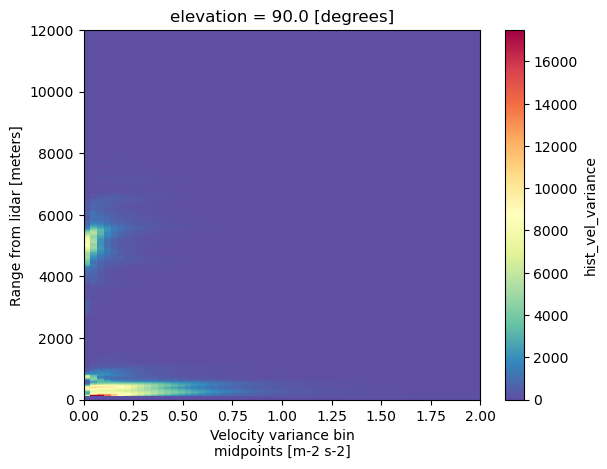

In [14]:
pdf_ds['hist_vel_variance'].sum(dim='time').plot(cmap='Spectral_r')

In [26]:
ds = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/wfip3/caco/vad/caco.lidar.vad.202403*.nc')
ds = xr.concat([ds, xr.open_mfdataset('/lcrc/group/earthscience/rjackson/wfip3/caco/vad/caco.lidar.vad.2024022*.nc')], dim='time')
ds = xr.concat([ds, xr.open_mfdataset('/lcrc/group/earthscience/rjackson/wfip3/caco/vad/caco.lidar.vad.202404*.nc')], dim='time')
ds = xr.concat([ds, xr.open_mfdataset('/lcrc/group/earthscience/rjackson/wfip3/caco/vad/caco.lidar.vad.202405*.nc')], dim='time')

In [115]:
ds

<xarray.Dataset>
Dimensions:                (time: 24070, height: 400)
Coordinates:
  * time                   (time) datetime64[ns] 2024-03-01T02:00:29.375010 ....
  * height                 (height) float64 12.99 38.97 ... 1.035e+04 1.038e+04
Data variables:
    wind_speed             (time, height) float64 dask.array<chunksize=(447, 400), meta=np.ndarray>
    wind_direction         (time, height) float64 dask.array<chunksize=(447, 400), meta=np.ndarray>
    wind_speed_error       (time, height) float64 dask.array<chunksize=(447, 400), meta=np.ndarray>
    wind_direction_error   (time, height) float64 dask.array<chunksize=(447, 400), meta=np.ndarray>
    signal_to_noise_ratio  (time, height) float64 dask.array<chunksize=(447, 400), meta=np.ndarray>
    residual               (time, height) float64 dask.array<chunksize=(447, 400), meta=np.ndarray>
    correlation            (time, height) float64 dask.array<chunksize=(447, 400), meta=np.ndarray>

In [7]:
## Get list of nocturnal turbulence events
events_list = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTnIf4gb65iX3ceZYMFKsuzIKHmjKVbMNBVsL_1K3o4qDaPJf8Rs_KQA7iQbfKX5DAFLw4aQl2Lc7iq/pub?output=csv',
                          parse_dates=True, index_col='Date').fillna("")
events_list

,Nocturnal turbulence,Rain that day?,Clouds
Date,,,
2023-12-19,No,No,
2023-12-20,Yes,No,Cloud deck forms around 9 UTC
2023-12-21,no data,,
2023-12-22,Yes,no,only under cloud detected
2023-12-23,No,No,
...,...,...,...
2024-05-26,Yes,Yes,
2024-05-27,No,No,Cloudy night
2024-05-28,No,No,Cloudy night


In [15]:
events_list["Clouds"].values[-2]

TypeError: object of type 'float' has no len()

In [14]:
turb_event = np.logical_and(events_list["Nocturnal turbulence"].values == "Yes", 
                            events_list["Rain that day?"].values == "No")
turb_event = np.logical_and(turb_event, events_list["Clouds"].values == "")
non_turb_event =  np.logical_and(events_list["Nocturnal turbulence"].values == "No", 
                            events_list["Rain that day?"].values == "No")
non_turb_event = np.logical_and(non_turb_event, events_list["Clouds"].values == "")
turb_event = np.where(turb_event, 1, 0)
turb_event[non_turb_event == 1] = 2
turb_event

array([2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0,
       0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0,
       0, 0, 0, 1, 1, 0, 0, 2, 1, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 1,
       0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0,
       2, 1, 0, 0, 0, 2, 0])

In [15]:
events_ds = events_list.to_xarray()
events_ds

<xarray.Dataset> Size: 4kB
Dimensions:               (Date: 117)
Coordinates:
  * Date                  (Date) datetime64[ns] 936B 2023-12-19 ... 2024-05-30
Data variables:
    Nocturnal turbulence  (Date) object 936B 'No' 'Yes' 'no data' ... 'No' 'Yes'
    Rain that day?        (Date) object 936B 'No' 'No' '' ... 'No' 'No' 'Yes'
    Clouds                (Date) object 936B '' ... 'Clouds '

In [16]:
events_ds['turb_event'] = ('Date', turb_event)
events_ds

<xarray.Dataset> Size: 5kB
Dimensions:               (Date: 117)
Coordinates:
  * Date                  (Date) datetime64[ns] 936B 2023-12-19 ... 2024-05-30
Data variables:
    Nocturnal turbulence  (Date) object 936B 'No' 'Yes' 'no data' ... 'No' 'Yes'
    Rain that day?        (Date) object 936B 'No' 'No' '' ... 'No' 'No' 'Yes'
    Clouds                (Date) object 936B '' ... 'Clouds '
    turb_event            (Date) int64 936B 2 0 0 0 2 0 0 0 ... 0 2 1 0 0 0 2 0

In [12]:
ds_sonic_4m = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/wfip3/caco/sonic/caco.sonic.z01.b1.daily.*.nc')
ds_sonic_10m = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/wfip3/caco/sonic/caco.sonic.z02.b1.daily.*.nc')

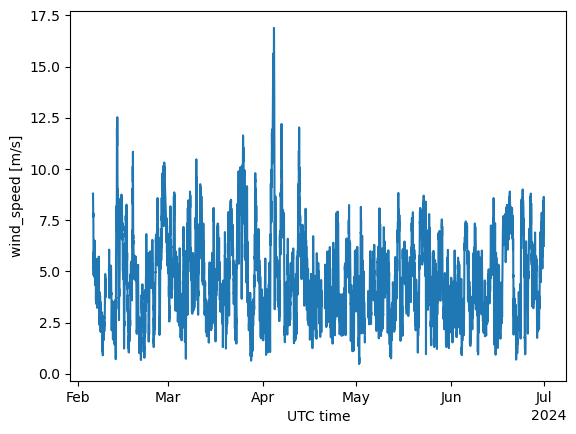

In [35]:
ds_sonic_10m["wind_speed"].plot()

In [27]:
tevent = events_ds['turb_event'].reindex(Date=ds.time.values, method='nearest')
tevent_sonic_4m = events_ds['turb_event'].reindex(Date=ds_sonic_4m.time.values, method='nearest')
tevent_sonic_10m = events_ds['turb_event'].reindex(Date=ds_sonic_10m.time.values, method='nearest')

In [70]:
ds_vad_resample = vad_ds.resample(time='30m').mean().reindex(time=ds_sonic_10m.time, method='nearest')

In [74]:
vert_shear_spd = ds_vad_resample["wind_speed"].sel(height=250., method='nearest') - ds_sonic_10m["wind_speed"]

In [110]:
vad_ds.resample(time='30min').mean()

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1514b4e0fa50>>
Traceback (most recent call last):
  File "/gpfs/fs1/home/rjackson/mambaforge/envs/crocus_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


<xarray.Dataset> Size: 108MB
Dimensions:                (height: 400, time: 4811)
Coordinates:
  * height                 (height) float64 3kB 12.99 38.97 ... 1.038e+04
  * time                   (time) datetime64[ns] 38kB 2024-02-20T18:00:00 ......
Data variables:
    wind_speed             (time, height) float64 15MB dask.array<chunksize=(2, 400), meta=np.ndarray>
    wind_direction         (time, height) float64 15MB dask.array<chunksize=(2, 400), meta=np.ndarray>
    wind_speed_error       (time, height) float64 15MB dask.array<chunksize=(2, 400), meta=np.ndarray>
    wind_direction_error   (time, height) float64 15MB dask.array<chunksize=(2, 400), meta=np.ndarray>
    signal_to_noise_ratio  (time, height) float64 15MB dask.array<chunksize=(2, 400), meta=np.ndarray>
    residual               (time, height) float64 15MB dask.array<chunksize=(2, 400), meta=np.ndarray>
    correlation            (time, height) float64 15MB dask.array<chunksize=(2, 400), meta=np.ndarray>
    turb_event             (time) float64 38kB nan nan nan nan ... nan nan nan

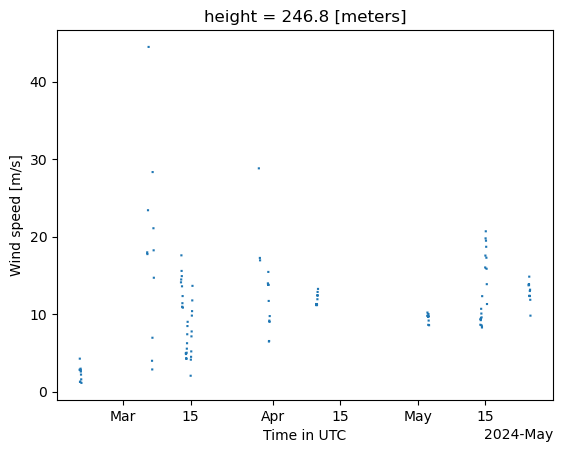

In [116]:
vad_ds_resampled["wind_speed"].plot()


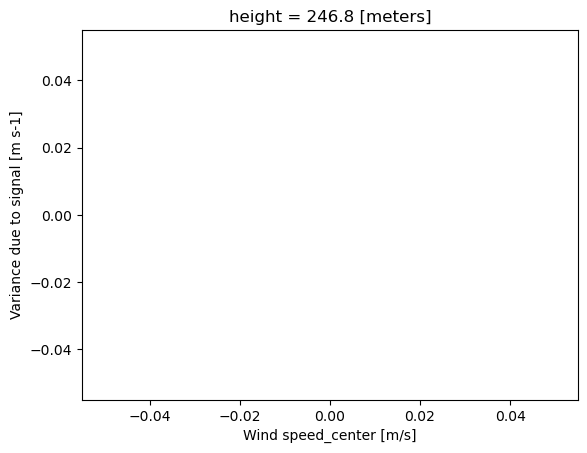

In [142]:
cluster = 0
vad_ds_resampled = vad_ds.reindex(time=variance_stats.time, method='nearest').sel(height=250., method='nearest')
variance_stats["atmos_variance"].isel(range=8).where(np.logical_and(
    vad_ds_resampled.turb_event == cluster, vad_ds_resampled.time.dt.hour < 11)).where(variance_stats["noise_variance"].isel(range=8) < 1).groupby_bins(
        vad_ds_resampled.wind_speed, bins=np.linspace(0, 20, 20)).mean().plot()

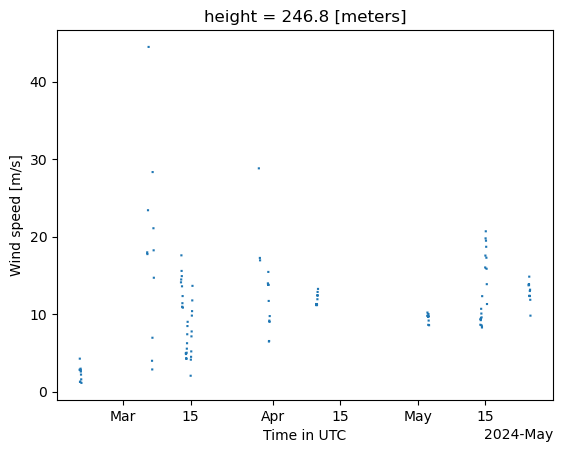

In [125]:
vad_ds_resampled.wind_speed.plot()

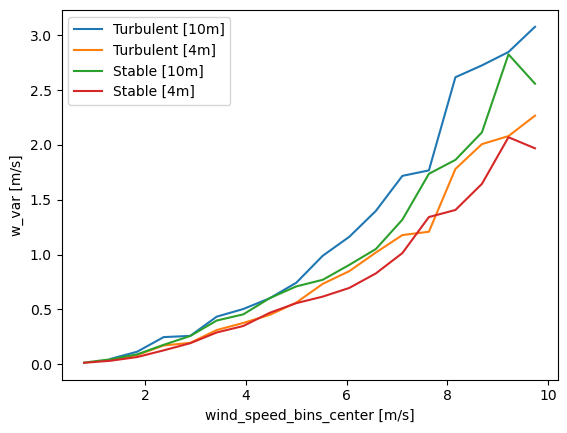

In [143]:
cluster = 1
ds_sonic_10m["w_var"].where(ds_sonic_10m.turb_event == cluster).groupby_bins(ds_sonic_10m.wind_speed, bins=np.linspace(0, 10, 20)).mean().plot(label="Turbulent [10m]")
ds_sonic_4m["w_var"].where(ds_sonic_4m.turb_event == cluster).groupby_bins(ds_sonic_10m.wind_speed, bins=np.linspace(0, 10, 20)).mean().plot(label="Turbulent [4m]")
cluster = 2
ds_sonic_10m["w_var"].where(ds_sonic_10m.turb_event == cluster).groupby_bins(ds_sonic_10m.wind_speed, bins=np.linspace(0, 10, 20)).mean().plot(label="Stable [10m]")
ds_sonic_4m["w_var"].where(ds_sonic_4m.turb_event == cluster).groupby_bins(ds_sonic_10m.wind_speed, bins=np.linspace(0, 10, 20)).mean().plot(label="Stable [4m]")
plt.legend()

Text(0, 0.5, 'TKE [$m^{2}\\ s^{-2}$]')

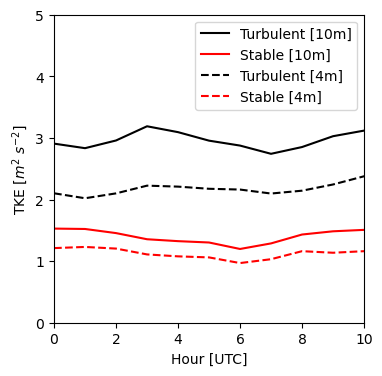

In [57]:
plt.figure(figsize=(4, 4))
ds_sonic_10m['TKE'] = (ds_sonic_10m["u_var"] + ds_sonic_10m["v_var"] + ds_sonic_10m["w_var"]) / 2.
cluster = 1
ds_sonic_10m['TKE'].where(ds_sonic_10m.turb_event == cluster).groupby("time.hour").mean().plot(label='Turbulent [10m]', color='k')
cluster = 2
ds_sonic_10m['TKE'].where(ds_sonic_10m.turb_event == cluster).groupby("time.hour").mean().plot(label='Stable [10m]', color='r')
ds_sonic_4m['TKE'] = (ds_sonic_4m["u_var"] + ds_sonic_4m["v_var"] + ds_sonic_4m["w_var"]) / 2.
cluster = 1
ds_sonic_4m['TKE'].where(ds_sonic_4m.turb_event == cluster).groupby("time.hour").mean().plot(label='Turbulent [4m]', color='k', linestyle='--')
cluster = 2
ds_sonic_4m['TKE'].where(ds_sonic_4m.turb_event == cluster).groupby("time.hour").mean().plot(label='Stable [4m]', color='r', linestyle='--')
plt.xlim([0, 10])
plt.ylim([0, 5])
plt.legend()
plt.xlabel('Hour [UTC]')
plt.ylabel('TKE [$m^{2}\ s^{-2}$]')

Text(0, 0.5, 'Hub height - 10m wind speed')

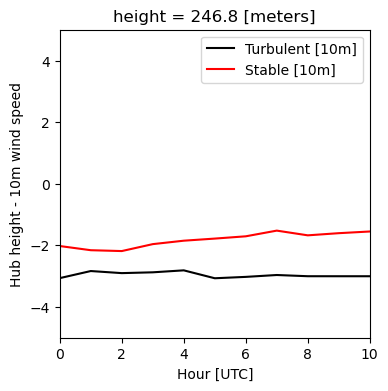

In [76]:
plt.figure(figsize=(4, 4))

cluster = 1
vert_shear_spd.where(ds_sonic_10m.turb_event == cluster).groupby("time.hour").mean().plot(label='Turbulent [10m]', color='k')
cluster = 2
vert_shear_spd.where(ds_sonic_10m.turb_event == cluster).groupby("time.hour").mean().plot(label='Stable [10m]', color='r')
plt.xlim([0, 10])
plt.ylim([-5, 5])
plt.legend()
plt.xlabel('Hour [UTC]')
plt.ylabel('Hub height - 10m wind speed')

In [28]:
ds['turb_event'] = ('time', tevent.values)
ds_sonic_4m['turb_event'] = ('time', tevent_sonic_4m.values)
ds_sonic_10m['turb_event'] = ('time', tevent_sonic_10m.values)

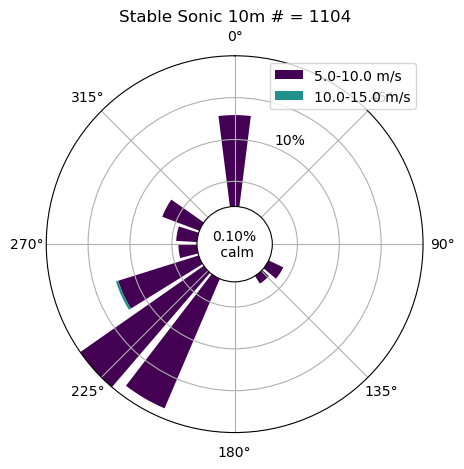

In [41]:
cluster = 2
disp = act.plotting.WindRoseDisplay(ds_sonic_10m.where(ds_sonic_10m.turb_event == cluster))
disp.plot("wind_direction", "wind_speed", tick_interval=10, spd_bins=[5, 10, 15])
plt.title("Stable Sonic 10m # = %d" % np.sum(ds_sonic_10m.turb_event == cluster))
disp.axes[0].set_rlim([2, 20])
disp.axes[0].set_rticks([5, 10, 15])
plt.tight_layout()
plt.savefig('wind_cluster%d_10m_sonic.png' % (cluster+1), bbox_inches='tight')

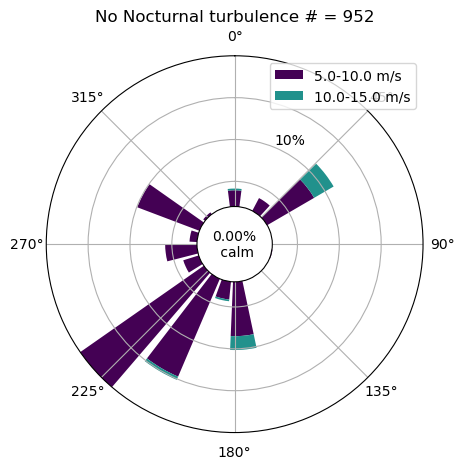

In [42]:
cluster = 1
disp = act.plotting.WindRoseDisplay(ds_sonic_10m.where(ds_sonic_10m.turb_event == cluster))
disp.plot("wind_direction", "wind_speed", tick_interval=10, spd_bins=[5, 10, 15])
plt.title("Nocturnal turbulence # = %d" % np.sum(ds_sonic_10m.turb_event == cluster))
disp.axes[0].set_rlim([2, 20])
disp.axes[0].set_rticks([5, 10, 15])
plt.tight_layout()
plt.savefig('wind_cluster%d_10m_sonic.png' % (cluster+1), bbox_inches='tight')

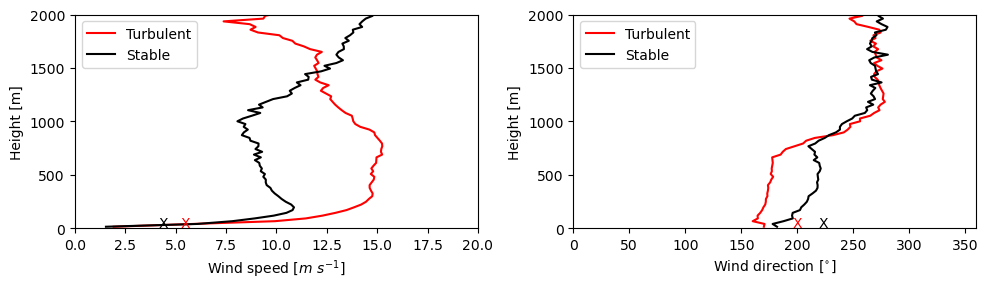

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
labels = ["Turbulent", "Stable"]
colors = ['r', 'k']
for cluster in [1, 2]:
    vad_ds = ds.where(ds.turb_event == cluster).sortby("time")
    vad_ds = vad_ds.where(vad_ds.time.dt.hour < 10) 
    ds_10m = ds_sonic_10m.where(ds_sonic_10m.turb_event == cluster).sortby("time")
    ds_10m = ds_10m.where(ds_10m.time.dt.hour < 10)
    ax[0].text(ds_10m["wind_speed"].mean(dim='time').values, 10, 'X', color=colors[cluster - 1] )
    ax[1].text(ds_10m["wind_direction"].mean(dim='time').values, 10, 'X', color=colors[cluster - 1])
    vad_ds["wind_speed"].mean(dim='time').T.plot(ax=ax[0], y='height', color=colors[cluster - 1], label=labels[cluster - 1])
    vad_ds["wind_direction"].mean(dim='time').T.plot(ax=ax[1], y='height', color=colors[cluster - 1], label=labels[cluster - 1])
ax[0].set_ylim([0, 2000])
ax[0].set_ylabel('Height [m]')
ax[1].set_ylabel('Height [m]')
ax[0].set_xlabel('Wind speed [$m\ s^{-1}$]')
ax[1].set_xlabel('Wind direction [$^{\circ}$]')
ax[0].legend()
ax[1].set_ylim([0, 2000])
ax[1].legend()
ax[0].set_xlim([0, 20])
ax[1].set_xlim([0, 360])
fig.tight_layout()

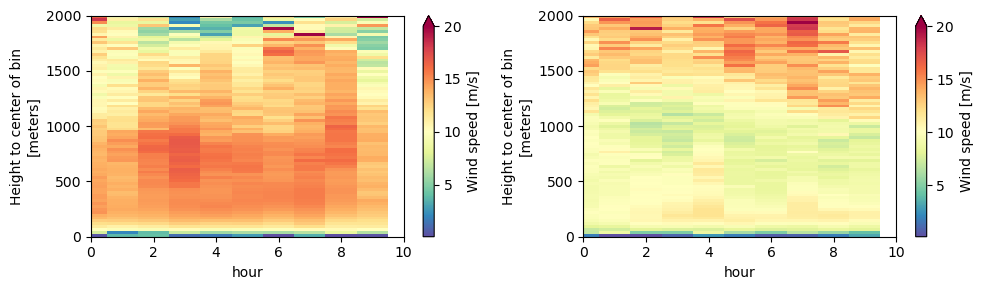

In [129]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
labels = ["Turbulent", "Stable"]
for cluster in [1, 2]:
    vad_ds = ds.where(ds.turb_event == cluster).sortby("time")
    vad_ds = vad_ds.where(vad_ds.time.dt.hour < 10)
    vad_ds_hour = vad_ds.groupby("time.hour").mean()
    vad_ds_hour["wind_speed"].T.plot(ax=ax[cluster-1], vmax=20, cmap="Spectral_r")
ax[0].set_xlim([0, 10])
ax[1].set_xlim([0, 10])
ax[0].set_ylim([0, 2000])
ax[1].set_ylim([0, 2000])
fig.tight_layout()

In [82]:
variance_stats['range'] = (['range'], 30*np.arange(1, variance_stats.sizes["range"]+1))

In [87]:
variance_stats = variance_stats.where(variance_stats["range"] > 100.)
variance_stats = variance_stats.where(variance_stats.time.dt.hour < 10)

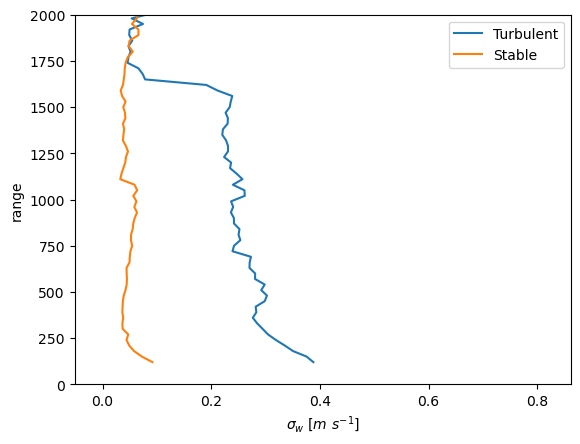

In [88]:
variance_stats['atmos_variance'].where(
    np.logical_and(variance_stats['noise_variance'] < 1, variance_stats['turb_event'] == 1)).T.mean(dim='time').plot(
        y='range', label="Turbulent")
variance_stats['atmos_variance'].where(
    np.logical_and(variance_stats['noise_variance'] < 1, variance_stats['turb_event'] == 2)).T.mean(dim='time').plot(
        y='range', label="Stable")
plt.ylim([0, 2000])
plt.xlabel('$\sigma_w$ [$m\ s^{-1}$]')
plt.ylabel('range')
plt.legend()

(-2.0, 0.0)

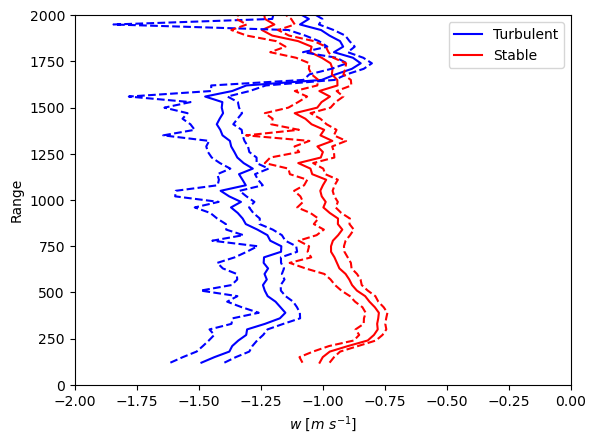

In [97]:
variance_stats['w_50'].where(
    np.logical_and(variance_stats['noise_variance'] < 1, variance_stats['turb_event'] == 1)).T.mean(dim='time').plot(
        y='range', label="Turbulent", color='b')
variance_stats['w_50'].where(
    np.logical_and(variance_stats['noise_variance'] < 1, variance_stats['turb_event'] == 2)).T.mean(dim='time').plot(
        y='range', label="Stable", color='r')
variance_stats['w_25'].where(
    np.logical_and(variance_stats['noise_variance'] < 1, variance_stats['turb_event'] == 1)).T.mean(dim='time').plot(
        y='range', color='b', linestyle='--')
variance_stats['w_25'].where(
    np.logical_and(variance_stats['noise_variance'] < 1, variance_stats['turb_event'] == 2)).T.mean(dim='time').plot(
        y='range', color='r', linestyle='--')
variance_stats['w_75'].where(
    np.logical_and(variance_stats['noise_variance'] < 1, variance_stats['turb_event'] == 1)).T.mean(dim='time').plot(
        y='range', color='b', linestyle='--')
variance_stats['w_75'].where(
    np.logical_and(variance_stats['noise_variance'] < 1, variance_stats['turb_event'] == 2)).T.mean(dim='time').plot(
        y='range', color='r', linestyle='--')
plt.ylim([0, 2000])
plt.xlabel('$w$ [$m\ s^{-1}$]')
plt.ylabel('Range')
plt.legend()
plt.xlim([-2, 0])

<Axes: title={'center': 'Turbulent'}, xlabel='hour', ylabel='range'>

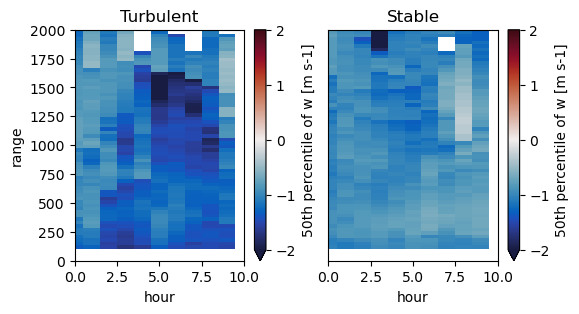

In [113]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
variance_stats['w_50'].where(
    np.logical_and(variance_stats['noise_variance'] < 1, variance_stats['turb_event'] == 1)).T.groupby("time.hour").mean().plot(
        vmin=-2, vmax=2, cmap='balance', ax=ax[0]
    )
ax[0].set_xlim([0, 10])
ax[0].set_ylim([0, 2000])
ax[0].set_title("Turbulent")
variance_stats['w_50'].where(
    np.logical_and(variance_stats['noise_variance'] < 1, variance_stats['turb_event'] == 2)).T.groupby("time.hour").mean().plot(
        vmin=-2, vmax=2, cmap='balance', ax=ax[1]
    )
ax[1].set_xlim([0, 10])
ax[1].set_ylim([0, 2000])
ax[1].set_title("Stable")
ax[1].set_ylabel("")
ax[1].set_yticks([])
ax[0]


<Axes: title={'center': 'Turbulent'}, xlabel='hour', ylabel='Hour [UTC]'>

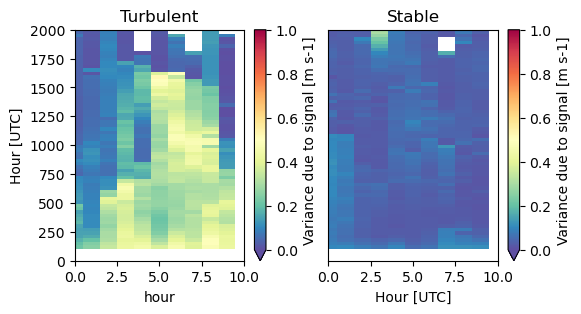

In [112]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
variance_stats['atmos_variance'].where(
    np.logical_and(variance_stats['noise_variance'] < 1, variance_stats['turb_event'] == 1)).T.groupby("time.hour").mean().plot(
        vmin=0, vmax=1, cmap='Spectral_r', ax=ax[0]
    )
ax[0].set_xlim([0, 10])
ax[0].set_ylim([0, 2000])
ax[0].set_title("Turbulent")
variance_stats['atmos_variance'].where(
    np.logical_and(variance_stats['noise_variance'] < 1, variance_stats['turb_event'] == 2)).T.groupby("time.hour").mean().plot(
        vmin=0, vmax=1, cmap='Spectral_r', ax=ax[1]
    )
ax[1].set_xlim([0, 10])
ax[1].set_ylim([0, 2000])
ax[1].set_title("Stable")
ax[1].set_ylabel("")
ax[1].set_xlabel("Hour [UTC]")
ax[0].set_ylabel("Hour [UTC]")
ax[1].set_yticks([])
ax[0]

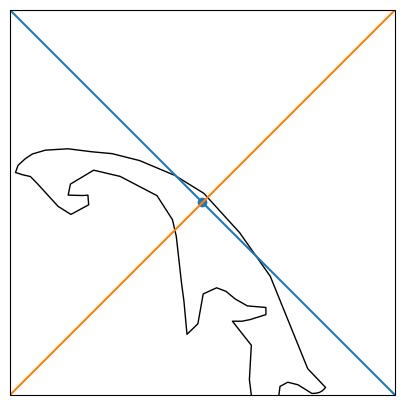

In [81]:
highlands_center = (42.03025826535351, -70.0525613525932)
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([highlands_center[1]-0.2, highlands_center[1]+0.2, highlands_center[0]-0.2, highlands_center[0]+0.2])
slope_315 = np.tan(np.deg2rad(135))
slope_45 = np.tan(np.deg2rad(45))
x = np.linspace(highlands_center[1]+0.2, highlands_center[1] - 0.2)
y_315 = highlands_center[0] + slope_315 * (x - highlands_center[1])
y_45 = highlands_center[0] + slope_45 * (x - highlands_center[1])
ax.plot(x, y_315, label='315 degrees')
ax.plot(x, y_45, label='45 degrees')
ax.coastlines(resolution='10m')
ax.scatter(highlands_center[1], highlands_center[0])